Split the protocol into training, validation and testing set and then augment and train.

In [32]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [34]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]

# Create train/vali and test data frame
np.random.seed(0)
data_1_train_idx = np.random.randint(0,len(data1),size=int(len(data1)/2))
data_1_test_idx = np.setdiff1d(np.arange(0,len(data1),1), data_1_train_idx)

data1_train = data1.loc[data_1_train_idx]
data1_test = data1.loc[data_1_test_idx]

data1_gen_train, targets1_train = dw_gen.STDP_dw_gen(n_neighbors=3, df_ori=data1_train)
data1_gen_test, targets1_test = dw_gen.STDP_dw_gen(n_neighbors=3, df_ori=data1_test)

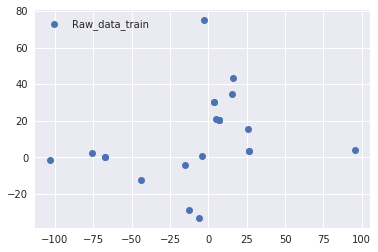

In [28]:
plt.plot(data1_train['dt1'], data1_train['dw_mean'],'o', label='Raw_data_train')
#plt.plot(data1_test['dt1'], data1_test['dw_mean'],'o', label='Raw_data_test')

width_list = np.concatenate([np.linspace(10,3,50), np.linspace(1,10,50)])
# targets1_sm = dw_gen.smooth(targets1,width_list = width_list)
# plt.plot(data1_gen['dt1'],targets1_sm,'o', label='Smoothness filter')
# plt.xlabel('dt(ms)')
# plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

In [5]:
len_sc = np.concatenate([np.linspace(1,0.5,11),np.linspace(0.5,1,11)]).reshape(-1,1)

In [29]:
data1_train['dw_mean'].shape

(22,)

In [30]:
data1_gen_train['dt1'].shape

(100,)

In [31]:
# Testing Gaussian Process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = RBF(length_scale=1.25, length_scale_bounds=(1e-05, 100000.0))+WhiteKernel(0.0001)
gp_rg = GaussianProcessRegressor(kernel=kernel)
gp_rg.fit(data1_train['dt1'], data1_train['dw_mean'])
y_train = gp_rg.predict(data1_gen_train['dt1'])
plt.plot(data1_train['dt1'], data1_train['dw_mean'],'o', label='Raw_data_train')
plt.plot(data1_gen_train['dt1'], y_train, label='KNN_train')
#plt.plot(data1_gen_test['dt1'], targets1_test,'o', label='KNN_test')

width_list = np.concatenate([np.linspace(10,3,50), np.linspace(3,10,50)])
targets1_sm_train = dw_gen.smooth(targets1_train, width_list=width_list)
targets1_sm_test= dw_gen.smooth(targets1_test, width_list=width_list)

plt.legend()

ValueError: Found input variables with inconsistent numbers of samples: [1, 22]

In [ ]:
% debug

In [ ]:
plt.plot(data1_gen_train['dt1'],targets1_sm_train,'o', label='Smoothness train')
plt.plot(data1_gen_test['dt1'],targets1_sm_test,'o', label='Smoothness test')

In [ ]:
# Sample randomly the smoothed STDP data
samp_len = len(targets1_sm_train)
np.random.seed(1)
vali_idx_stdp = np.unique(np.random.randint(low=0, high=100, size=20))
train_idx_stdp = np.setdiff1d(train_vali_idx, vali_idx_stdp).astype(int)
plt.plot(data1_gen.loc[train_idx_stdp]['dt1'],targets1_sm[train_idx_stdp],'o', label='train_data')
plt.plot(data1_gen.loc[vali_idx_stdp]['dt1'],targets1_sm[vali_idx_stdp],'o', label='vali_data')
plt.plot(data1_gen.loc[test_idx_stdp]['dt1'],targets1_sm[test_idx_stdp],'o', label='test_data')
plt.legend()
print(len(set(train_idx_stdp)), len(set(vali_idx_stdp)), len(set(test_idx_stdp)))

In [ ]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data2_gen, targets2 = dw_gen.triplet_dw_gen(dt)

In [ ]:
# Visualize the triplet data
data2_gen

In [ ]:
# Generate data for Quadruplet
data3 = data[data['ptl_idx']==3]
data3_gen, targets3 = dw_gen.quad_dw_gen(n_neighbors=7)

In [ ]:
width_list = np.concatenate([np.linspace(10,3,45), np.linspace(3,10,45)])
plt.plot(data3['dt2'], data3['dw_mean'],'o', label='Raw data')
plt.plot(data3_gen['dt2'], targets3,'o', label='KNN')
targets3_sm = np.concatenate([dw_gen.smooth(targets3[:45],width_list = width_list), dw_gen.smooth(targets3[45:],width_list = width_list)])
plt.plot(data3_gen['dt2'],targets3_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

In [ ]:
# Sample randomly the smoothed Quadruplet data
samp_len = len(targets3_sm)
np.random.seed(1)
test_idx_quad = np.unique(np.random.randint(low=0, high=90, size=9))
train_vali_idx = np.setdiff1d(np.linspace(0,89,90), test_idx_quad).astype(int)
np.random.seed(10)
vali_idx_idx = np.random.randint(low=0, high=80, size=18)
vali_idx_quad = np.unique(train_vali_idx[vali_idx_idx])
train_idx_quad = np.setdiff1d(train_vali_idx, vali_idx_quad).astype(int)
plt.plot(data3_gen.loc[train_idx_quad]['dt2'],targets3_sm[train_idx_quad],'o', label='train_data')
plt.plot(data3_gen.loc[vali_idx_quad]['dt2'],targets3_sm[vali_idx_quad],'o', label='vali_data')
plt.plot(data3_gen.loc[test_idx_quad]['dt2'],targets3_sm[test_idx_quad],'o', label='test_data')
plt.legend()
print(len(set(train_idx_quad)), len(set(vali_idx_quad)), len(set(test_idx_quad)))

In [ ]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

In [ ]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen(len_kernel=101)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [ ]:
data_gen_train = pd.concat([data1_gen.loc[train_idx_stdp],data2_gen, data3_gen.loc[train_idx_quad]])
targets_gen_train = np.concatenate([targets1_sm[train_idx_stdp], targets2, targets3_sm[train_idx_quad]])

In [ ]:
data_gen_vali = pd.concat([data1_gen.loc[vali_idx_stdp], data2_gen, data3_gen.loc[vali_idx_quad]])
targets_gen_vali = np.concatenate([targets1_sm[vali_idx_stdp], targets2, targets3_sm[vali_idx_quad]])

In [ ]:
data_gen_test = pd.concat([data1_gen.loc[test_idx_stdp], data2_gen, data3_gen.loc[test_idx_quad]])
targets_gen_test = np.concatenate([targets1_sm[test_idx_stdp], targets2, targets3_sm[test_idx_quad]])

In [ ]:
# len_stdp = len(vali_idx_stdp)*
# len_triplet = len(vali_idx_stdp)*20+len(data2_gen[data2_gen['ptl_idx']==2])*40
# len_trip2 = len(vali_idx_stdp)*20+len(data2_gen[data2_gen['ptl_idx']==2])*40+len(data2_gen[data2_gen['ptl_idx']==4])*40
# len_quad = len(targets_gen_vali) - len_trip2

In [ ]:
data_gen_train['ptl_idx'].value_counts()

In [ ]:
# Generat the spike trains and targets for STDP
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [20,40,40,20]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train, ptl_list=ptl_list, targets=targets_gen_train, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [ ]:
# Generat the spike trains and targets for Quadruplet
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [20,40,40,20]
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=targets_gen_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [ ]:
spk_pairs_train.shape, spk_pairs_vali.shape

In [ ]:
# Create the network
ground_truth_init = 0
reg_scale=(1, 1)
init_seed=(4,5,6,7)
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, init_seed=init_seed, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

In [ ]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug'
# optimizer_op = tf.train.GradientDescentOptimizer
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, optimizer_op=optimizer_op, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [ ]:
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

In [ ]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post,  label='ker_post_trained')
plt.legend()
print(fc_w, bias)

In [ ]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

In [ ]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1*w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [ ]:
# # Test effect of smoothed kernel
# w_pre_sm = w_pre
# w_post_sm = w_post 
# w_post_post_sm = w_post_post
# w_pre_sm[:50] = dw_gen.smooth(w_pre[:50], width=2)
# w_post_sm[:48] = dw_gen.smooth(w_post[:48], width=2)
# w_post_post_sm[:49] = dw_gen.smooth(w_post_post[:49], width=3)

# plt.plot(-1 * w_pre_sm)
# plt.plot(-1 * w_post_sm)
# plt.plot(-1*w_post_post_sm)

# ker_test.kernel_pre = w_pre_sm
# ker_test.kernel_post = w_post_sm
# ker_test.kernel_post_post= w_post_post_sm
# ker_test.kernel_scale = fc_w
# ker_test.bias = bias

Compare the target and prediction

In [ ]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

In [ ]:
# Generate training predictions
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_train, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [ ]:
ptl_len = [len(train_idx_stdp), len(data2_gen[data2_gen['ptl_idx']==2]), len(data2_gen[data2_gen['ptl_idx']==4]), len(train_idx_quad)]
ptl_whole_len, targets_ptl, predictions_ptl = dw_gen.target_pred_gen(targets_train, predictions, ptl_len, [20, 40, 40, 20])

In [ ]:
ptl_name = ['stdp', 'triplet', 'trip2', 'quadruplet']
x_fit = np.linspace(np.min(targets_vali)-1, np.max(targets_vali)+1, 100)
for i in range(len(ptl_len)):
    plt.plot(np.linspace(-30,70,100),np.linspace(-30,70,100), 'k--' )
    # R2, corr, y_fit = perform_eval.R2_corr(predictions_ptl[i],targets_ptl[i], x_fit)
    plt.plot(targets_ptl[i], predictions_ptl[i], 'o', label=ptl_name[i]+'(n={a})'.format(a=targets_ptl[i].shape[0]))

R2, corr, y_fit = perform_eval.R2_corr(predictions,targets_train, x_fit)    
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()

In [ ]:
# Generat the spike trains and targets for Quadruplet
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [1,1,1,1]
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=targets_gen_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [ ]:
# Generate validation predictions
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [ ]:
ptl_len = [len(vali_idx_stdp), len(data2_gen[data2_gen['ptl_idx']==2]), len(data2_gen[data2_gen['ptl_idx']==4]), len(vali_idx_quad)]
ptl_whole_len, targets_ptl, predictions_ptl = dw_gen.target_pred_gen(targets_vali, predictions, ptl_len, aug_times)

In [ ]:
ptl_name = ['stdp', 'triplet', 'trip2', 'quadruplet']
x_fit = np.linspace(np.min(targets_vali)-1, np.max(targets_vali)+1, 100)
for i in range(len(ptl_len)):
    plt.plot(np.linspace(-30,70,100),np.linspace(-30,70,100), 'k--' )
    # R2, corr, y_fit = perform_eval.R2_corr(predictions_ptl[i],targets_ptl[i], x_fit)
    plt.plot(targets_ptl[i], predictions_ptl[i], 'o', label=ptl_name[i]+'(n={a})'.format(a=targets_ptl[i].shape[0]))

R2, corr, y_fit = perform_eval.R2_corr(predictions,targets_vali, x_fit)    

plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()

In [ ]:
# Generat the spike trains and targets for Quadruplet
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]
spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test, targets=targets_gen_test, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)
test= spk_pairs_test

Generate test restuls

In [ ]:
# Generate validation predictions
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [ ]:
ptl_len = [len(test_idx_stdp), len(data2_gen[data2_gen['ptl_idx']==2]), len(data2_gen[data2_gen['ptl_idx']==4]), len(test_idx_quad)]
ptl_whole_len, targets_ptl, predictions_ptl = dw_gen.target_pred_gen(targets_test, predictions, ptl_len, aug_times)

In [ ]:
ptl_name = ['Stdp', 'Triplet', 'Trip2', 'Quadruplet']
x_fit = np.linspace(np.min(targets_vali)-1, np.max(targets_vali)+1, 100)
for i in range(len(ptl_len)):
    plt.plot(np.linspace(-30,70,100),np.linspace(-30,70,100), 'k--' )
    # R2, corr, y_fit = perform_eval.R2_corr(predictions_ptl[i],targets_ptl[i], x_fit)
    plt.plot(targets_ptl[i], predictions_ptl[i], 'o', label=ptl_name[i]+'(n={a})'.format(a=targets_ptl[i].shape[0]))

R2, corr, y_fit = perform_eval.R2_corr(predictions,targets_test, x_fit)    

plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()